# SummedFields


In some oceanographic applications, you may want to advect particles using a combination of different velocity data sets. For example, particles at the surface are transported by a combination of geostrophic, Ekman and Stokes flow. And often, these flows are not even on the same grid.

One option would be to write a `Kernel` that computes the movement of particles due to each of these flows. However, in Parcels it is possible to directly combine different flows (without interpolation) and feed them into the built-in `AdvectionRK4` kernel. For that, we use so-called `SummedField` objects.

This tutorial shows how to use these `SummedField` with a very idealised example. We start by importing the relevant modules.


In [1]:
%matplotlib inline
import numpy as np

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    plotTrajectoriesFile,
)

Now, let's first define a zonal and meridional velocity field on a 1kmx1km grid with a flat mesh. The zonal velocity is uniform and 1 m/s, and the meridional velocity is zero everywhere.


In [2]:
xdim, ydim = (10, 20)
Uflow = Field(
    "U",
    np.ones((ydim, xdim), dtype=np.float32),
    lon=np.linspace(0.0, 1e3, xdim, dtype=np.float32),
    lat=np.linspace(0.0, 1e3, ydim, dtype=np.float32),
)
Vflow = Field("V", np.zeros((ydim, xdim), dtype=np.float32), grid=Uflow.grid)
fieldset_flow = FieldSet(Uflow, Vflow)

We then run a particle and plot its trajectory


INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libc347fc3eb8c553afd3519aa626a51dea_0.so


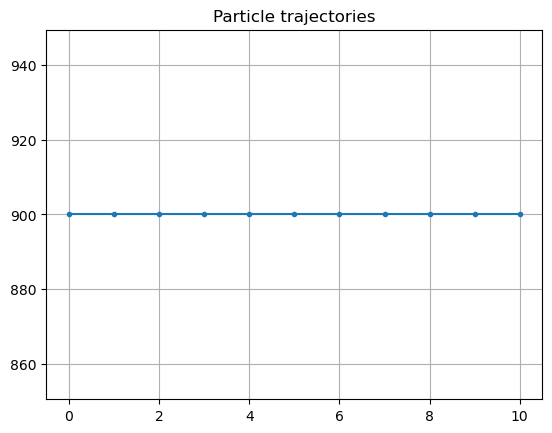

In [3]:
pset = ParticleSet(fieldset_flow, pclass=JITParticle, lon=[0], lat=[900])
output_file = pset.ParticleFile(name="SummedFieldParticle_flow.zarr", outputdt=1)
pset.execute(AdvectionRK4, runtime=10, dt=1, output_file=output_file)

plotTrajectoriesFile("SummedFieldParticle_flow.zarr");

The trajectory plot shows a particle moving eastward on the 1 m/s flow, as expected


Now, let's define another set of velocities (`Ustokes, Vstokes`) on a different, higher-resolution grid. This flow is southward at -0.2 m/s.


In [4]:
gf = 10  # factor by which the resolution of this grid is higher than of the original one.
Ustokes = Field(
    "U",
    np.zeros((ydim * gf, xdim * gf), dtype=np.float32),
    lon=np.linspace(0.0, 1e3, xdim * gf, dtype=np.float32),
    lat=np.linspace(0.0, 1e3, ydim * gf, dtype=np.float32),
)
Vstokes = Field(
    "V", -0.2 * np.ones((ydim * gf, xdim * gf), dtype=np.float32), grid=Ustokes.grid
)
fieldset_stokes = FieldSet(Ustokes, Vstokes)

We run a particle in this `FieldSet` and also plot its trajectory


INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib6658a4b49b4e75075bf93980bf149f54_0.so


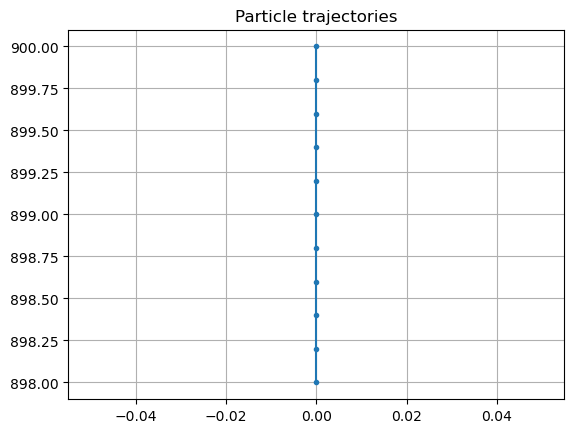

In [5]:
pset = ParticleSet(fieldset_stokes, pclass=JITParticle, lon=[0], lat=[900])
output_file = pset.ParticleFile(name="SummedFieldParticle_stokes.zarr", outputdt=1)
pset.execute(AdvectionRK4, runtime=10, dt=1, output_file=output_file)

plotTrajectoriesFile("SummedFieldParticle_stokes.zarr");

Now comes the trick of the `SummedFields`. We can simply define a new `FieldSet` with a summation of different `Fields`, as in `U=fieldset_flow.U+fieldset_stokes.U`.


In [6]:
fieldset_sum = FieldSet(
    U=fieldset_flow.U + fieldset_stokes.U, V=fieldset_flow.V + fieldset_stokes.V
)

And if we then run the particle again and plot its trajectory, we see that it moves southeastward!


INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib0eef83302b5560f22eafa68459c08d6d_0.so


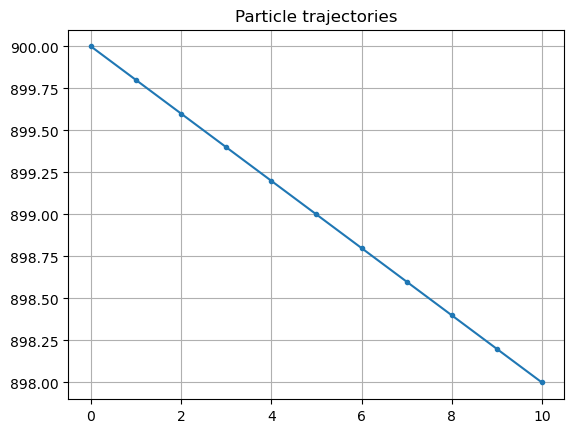

In [7]:
pset = ParticleSet(fieldset_sum, pclass=JITParticle, lon=[0], lat=[900])
output_file = pset.ParticleFile(name="SummedFieldParticle_sum.zarr", outputdt=1)
pset.execute(AdvectionRK4, runtime=10, dt=1, output_file=output_file)

plotTrajectoriesFile("SummedFieldParticle_sum.zarr");

What happens under the hood is that each `Field` in the `SummedField` is interpolated separately to the particle location, and that the different velocities are added in each step of the RK4 advection. So `SummedFields` are effortless to users.

Note that `SummedFields` work for any type of `Field`, not only for velocities. Any call to a `Field` interpolation (`fieldset.fld[time, lon, lat, depth]`) will return the sum of all `Fields` in the list if `fld` is a `SummedField`.
